In [1]:
# Core
import numpy as np
import pandas as pd

# Astronomy
import astropy
from astropy.units import au, minute

In [2]:
# Local imports
import kepler_sieve
from detection_near_ast import c, calc_det_near_ast
from asteroid_direction import calc_distance, calc_dir_linear, calc_dir_linear_topos
from asteroid_spline import make_spline_ast_vec, make_spline_ast_dir
from astro_utils import sec2dist, dist2sec
from db_utils import sp2df, df2db

In [3]:
# df = calc_det_near_ast(0, 10, 60.0)

In [4]:
# df

In [5]:
# Columns
cols_q_obs = ['qObs_x', 'qObs_y', 'qObs_z']
cols_q_ast = ['qAst_x', 'qAst_y', 'qAst_z']
cols_v_ast = ['vAst_x', 'vAst_y', 'vAst_z']
cols_u_obs = ['uObs_x', 'uObs_y', 'uObs_z']
cols_u_ast = ['uAst_x', 'uAst_y', 'uAst_z']

In [6]:
# Inputs
n0: int = 0
n1: int = 10
arcsec_max: float = 60.0

In [7]:
# Convert threshold from arc seconds to distance
s_max = sec2dist(arcsec_max)

In [8]:
# Get batch of candidates
sp_name = 'KS.GetDetectionNearAstCand'
params = {
    'AsteroidID_0': n0,
    'AsteroidID_1': n1,
}
df = sp2df(sp_name=sp_name, params=params)

In [10]:
df

,AsteroidID,DetectionID,tObs,qObs_x,qObs_y,qObs_z,uObs_x,uObs_y,uObs_z
0,1,31028109,58561.398970,-0.996391,0.038230,-0.000015,-0.296950,-0.948907,0.106752
1,1,31625219,58574.416979,-0.981920,-0.185324,0.000006,-0.277644,-0.955060,0.103802
2,1,31630218,58574.439919,-0.981847,-0.185716,0.000007,-0.277644,-0.955060,0.103802
3,1,33012558,58585.419479,-0.931212,-0.367257,0.000017,-0.275495,-0.956003,0.100801
4,1,33012561,58585.419479,-0.931212,-0.367257,0.000017,-0.275496,-0.956003,0.100802
...,...,...,...,...,...,...,...,...,...
599,9,76776086,58867.145220,-0.469237,0.874278,-0.000003,0.843577,0.536750,-0.016682
600,9,80856407,58887.107674,-0.742855,0.660783,0.000012,0.772122,0.635465,-0.003420
601,9,80856408,58887.107674,-0.742855,0.660783,0.000012,0.772389,0.635138,-0.003907
602,9,148572244,59251.420833,-0.734578,0.671400,0.000103,-0.920472,-0.371559,0.121140


In [11]:
df0 = df.copy()

In [12]:
# Extract arrays from DataFrame
asteroid_id: np.ndarray = df.AsteroidID.values
t_obs: np.ndarray = df.tObs.values
q_obs: np.ndarray = df[cols_q_obs].values
u_obs = df[cols_u_obs].values

In [13]:
# Get date range
mjd0: float = np.min(t_obs)
mjd1: float = np.max(t_obs)

In [14]:
# Build spline of asteroid vectors
spline_ast_vec = make_spline_ast_vec(n0=n0, n1=n1, mjd0=mjd0, mjd1=mjd1)

In [15]:
# Calculate asteroid directions and light time from spline and add to DataFrame
q_ast, v_ast = spline_ast_vec(ts=t_obs, asteroid_id=asteroid_id)
df[cols_q_ast] = q_ast
df[cols_v_ast] = v_ast

In [16]:
# # Delegate to calc_dir_linear_topos
# site_name = 'palomar'
# u1_ast, delta = calc_dir_linear_topos(q_tgt=q_ast, v_tgt=v_ast, t_obs=t_obs, site_name=site_name)

In [17]:
# Delegate to calc_dir_linear
u_ast, delta = calc_dir_linear(q_tgt=q_ast, v_tgt=v_ast, q_obs=q_obs)

In [18]:
# Light time from delta
light_time = delta / c

In [19]:
df[cols_u_ast] = u_ast

In [20]:
# Calculate distance between the detection and the asteroid
s = calc_distance(u_obs, u_ast)
df['s'] = s
df['LightTime'] = light_time

In [21]:
# Distance in arc seconds
s_sec = dist2sec(s)
df['s_sec'] = s_sec

In [22]:
# Mask down to only rows withing the maximum distance
mask = (s < s_max)
dfc = df[mask].reset_index(drop=True)

In [23]:
dfc

,AsteroidID,DetectionID,tObs,qObs_x,qObs_y,qObs_z,uObs_x,uObs_y,uObs_z,qAst_x,...,qAst_z,vAst_x,vAst_y,vAst_z,uAst_x,uAst_y,uAst_z,s,LightTime,s_sec
0,2,88465354,58966.453889,-0.804853,-0.603876,0.000116,0.390592,-0.692543,0.606483,0.379771,...,1.839763,0.008499,-0.000455,-0.000406,0.390610,-0.692367,0.606672,0.000259,25.219450,53.413089
1,2,95787525,59017.396319,-0.069434,-1.007055,0.000146,0.334459,-0.645153,0.686961,0.807200,...,1.799810,0.008254,0.000656,-0.001154,0.334492,-0.645316,0.686791,0.000238,21.793375,49.061891
2,2,103605382,59056.286563,0.554708,-0.840395,0.000141,0.220055,-0.703639,0.675624,1.122805,...,1.744374,0.007961,0.001468,-0.001691,0.220024,-0.703585,0.675691,0.000092,21.469217,18.987234
3,2,109726800,59080.212153,0.837323,-0.553326,0.000133,0.174561,-0.759870,0.626200,1.310684,...,1.700112,0.007739,0.001950,-0.002007,0.174348,-0.759830,0.626307,0.000241,22.574482,49.787912
4,3,80456383,58883.541782,-0.699831,0.705615,0.000031,-0.929531,-0.362874,0.065531,-2.927459,...,0.157777,-0.001636,-0.009150,0.002144,-0.929540,-0.362801,0.065812,0.000291,19.930758,59.974870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,6,150091323,59254.560729,-0.770827,0.630297,0.000120,0.036588,-0.981030,0.190370,-0.655343,...,0.600130,0.010013,-0.000991,-0.001547,0.036581,-0.981031,0.190370,0.000007,26.213978,1.442035
62,7,122087871,59135.126401,0.931756,0.346935,0.000099,0.130258,-0.989381,0.064487,1.242890,...,0.154259,0.007836,0.007894,0.000607,0.130076,-0.989406,0.064469,0.000184,19.886273,38.013007
63,8,25365817,58481.544410,-0.129079,0.982376,-0.000084,-0.763431,-0.639726,0.089012,-2.354147,...,0.259356,0.003060,-0.009492,0.000054,-0.763435,-0.639721,0.089013,0.000007,24.240099,1.350863
64,8,27872498,58506.540417,-0.536479,0.833255,-0.000064,-0.660481,-0.744274,0.099107,-2.264424,...,0.259224,0.004110,-0.009036,-0.000064,-0.660485,-0.744270,0.099106,0.000006,21.758858,1.188068


In [24]:
# Statistics for distance in seconds
sc = dfc.s_sec.values
s_mean_sec = np.mean(sc)
s_min_sec = np.min(sc)
s_max_sec = np.max(sc)

In [25]:
print(f'Distance in arc seconds for {dfc.shape[0]} rows within {arcsec_max} arc seconds:')
print(f'Mean: {s_mean_sec:6.2f}')
print(f'Min:  {s_min_sec:6.2f}')
print(f'Max:  {s_max_sec:6.2f}')

Distance in arc seconds for 66 rows within 60.0 arc seconds:
Mean:  14.33
Min:    0.03
Max:   59.97


In [26]:
mask_hit = (s_sec < 2.0)
dfh = df[mask_hit].reset_index(drop=True)

In [27]:
np.sum(mask_hit)

47

In [30]:
dfh

,AsteroidID,DetectionID,tObs,qObs_x,qObs_y,qObs_z,uObs_x,uObs_y,uObs_z,qAst_x,...,qAst_z,vAst_x,vAst_y,vAst_z,uAst_x,uAst_y,uAst_z,s,LightTime,s_sec
0,3,85817184,58940.414745,-0.982621,-0.198274,8.644541e-05,-0.963231,-0.232885,0.133978,-2.966884,...,0.276104,0.000216,-0.008884,0.002008,-0.963231,-0.232889,0.133977,3.497960e-06,17.132595,0.721506
1,3,94249102,59009.231481,-0.206265,-0.988062,1.394141e-04,-0.983392,-0.103063,0.149391,-2.882382,...,0.406713,0.002192,-0.008225,0.001778,-0.983392,-0.103061,0.149391,1.990094e-06,22.632745,0.410486
2,3,143151428,59221.571458,-0.297392,0.945355,8.707589e-05,-0.400793,-0.900156,0.170542,-1.906799,...,0.684982,0.006584,-0.004650,0.000787,-0.400798,-0.900154,0.170542,5.158967e-06,33.399125,1.064113
3,3,147333026,59248.508866,-0.698975,0.707656,1.060147e-04,-0.276412,-0.942109,0.189808,-1.724196,...,0.704212,0.006967,-0.004072,0.000640,-0.276416,-0.942108,0.189807,4.221502e-06,30.851084,0.870747
4,3,149520112,59253.541273,-0.759307,0.643853,1.168695e-04,-0.255190,-0.947207,0.194107,-1.688965,...,0.707363,0.007034,-0.003961,0.000612,-0.255194,-0.947206,0.194107,4.250498e-06,30.302335,0.876728
5,3,151045168,59256.525382,-0.792343,0.603621,1.203696e-04,-0.243025,-0.949853,0.196770,-1.667916,...,0.709166,0.007073,-0.003895,0.000596,-0.243028,-0.949852,0.196769,3.712384e-06,29.968300,0.765734
6,3,152694291,59263.522569,-0.861176,0.503040,1.269729e-04,-0.215898,-0.955006,0.203349,-1.618106,...,0.713197,0.007163,-0.003739,0.000557,-0.215901,-0.955006,0.203349,3.946255e-06,29.163312,0.813974
7,3,156186557,59275.484201,-0.948729,0.314848,1.346937e-04,-0.174801,-0.960687,0.215696,-1.531530,...,0.719451,0.007311,-0.003469,0.000489,-0.174804,-0.960687,0.215695,3.084396e-06,27.734975,0.636202
8,4,125865668,59146.497558,0.844026,0.522385,7.367395e-05,-0.869738,0.491112,0.048626,-1.587839,...,0.136047,-0.007572,-0.007490,0.001145,-0.869735,0.491119,0.048626,7.346001e-06,23.253290,1.515222
9,5,21070862,58437.228704,0.601305,0.792522,-8.633498e-05,0.974748,-0.207648,-0.082149,2.835824,...,-0.188416,-0.002565,0.009233,-0.000530,0.974748,-0.207648,-0.082149,1.372993e-07,19.065658,0.028320


In [35]:
dfh.groupby(dfh.AsteroidID).DetectionID.count()

AsteroidID
3     8
4     1
5    29
6     6
8     3
Name: DetectionID, dtype: int64

In [32]:
import matplotlib.pyplot as plt

(array([47.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  2.,  2.,
         4.,  4.,  2.,  4.,  1.,  8.,  3.,  4.,  1.,  2.,  0.,  2.,  4.,
         6.,  6.,  9.,  7.,  6.,  7.,  2.,  3., 10.,  2.,  3., 14., 13.,
         6., 10.,  6.,  3.,  8.,  4.,  9.,  5.,  9., 12.,  8.,  3.,  3.,
         7.,  7.,  6.,  7., 10., 10., 11.,  6., 12.,  6., 14.,  8., 10.,
         8., 13., 11.,  7.,  6.,  5.,  8.,  7.,  9.,  6.,  5., 10.,  2.,
         7.,  4.,  5.,  6.,  8.,  5.,  7.,  6.,  7.,  7.,  5.,  4.,  4.,
         3.,  7.,  8.,  4.,  3.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  2.,
         2.,  3.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  2.]),
 array([2.83200097e-02, 3.74254118e+00, 7.45676235e+00, 1.11709835e+01,
        1.48852047e+01, 1.85994259e+01, 2.23136470e+01, 2.60278682e+01,
        2.97420894e+01, 3.34563105e+01, 3.71705317e+01, 4.08847529e+01,
        4.45989740e+01, 4.83131952e+01, 5.20274164e+01, 5.57416375e+01,
        5.94558587e+01, 6.3170

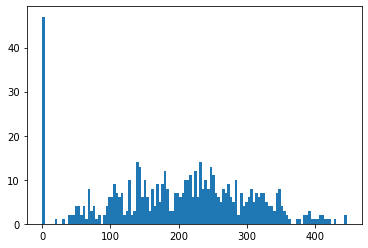

In [33]:
plt.hist(x=s_sec, bins=120)

(array([1., 0., 2., 2., 0., 0., 4., 4., 3., 7., 1., 1., 6., 7., 9., 0., 0.,
        0., 0.]),
 array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
        0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
        1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
        1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ]),
 <BarContainer object of 19 artists>)

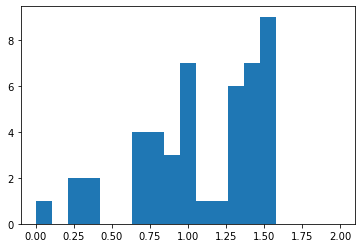

In [37]:
plt.hist(x=s_sec[mask_hit], bins=np.linspace(0.0, 2.0, 20))